## Figure 7

Analysis of feature correlation in topological featurization and use of featurization by extracting the largest subtribes in volumetric samples

In [1]:
from toposample import Config, TopoData
from toposample.data import read_h5_dataset, read_multiple_h5_datasets
from figure_helper import FigureHelper
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from helper_functions import samples_overlap
from plot_helpers import adjust_color_brightness
import json
import h5py
import numpy
from scipy.stats import ranksums, wilcoxon

"""
Set random seed, so that all figures are exactly reproducible
"""
numpy.random.seed(1234)

"""
Paths to relevant data.
"""
cfg = Config("../working_dir/config/common_config.json")
fn_tribes = cfg._cfg['analyzed']['tribes']
fn_features = cfg._cfg['analyzed']['features']
fn_features_acc = cfg._cfg['analyzed']['classifier_features_results']

"""
Additional parameterization, like which examples to plot and in which color
"""

# Manual selection of parametric sampling specifiers
specs_param = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']

# Panel-A
panel_a_show_points = True
panel_a_show_errbars = True

# Panel-B
param_spec_sel = ['Adjacency spectral gap (low)', 'Efferent extension rate'] # Two examples of specifiers (parameter sampling) with low/high correlation

# Panel-C
panel_c_show_errbars = True

# Panel-E
panel_e_show_points = True
panel_e_show_errbars = True

# Panel-F
panel_f_show_points = True
panel_f_show_errbars = True
panel_f_show_significance = True

# Panel-G
panel_g_show_errbars = True
panel_g_show_random = False

# Colors
col_param = 'tab:green' # Color for parameter sampling
col_vol = 'tab:blue' # Color for volumetric sampling
col_subtr = 'tab:red' # Color for subtribes in volumetric samples
col_rnd = 'tab:olive' # Color for subtribes in volumetric samples

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 7")

In [2]:
"""
Loading the data
"""
# Load tribes
tribe_gids = TopoData(fn_tribes)['gids']

# Load features (Euler characteristic values)
num_stimuli = 8
read_features = read_multiple_h5_datasets({f"stim{idx}": f"per_stimulus/stim{idx}" for idx in range(num_stimuli)})
ec_ftr = TopoData(fn_features, follow_link_functions={"data_fn": (read_features, True)})["data_fn"]
ec_ftr = ec_ftr.filter(index='0') # Assume that features are pooled to a single element at index '0'

# Merge feature trials of all stimuli
f_cat2 = lambda x: numpy.concatenate([x[k] for k in x.keys()], 2) # Concatenate along dim 2 (=trials)
ec_ftr = ec_ftr.map(f_cat2)

# Accuracies
read_scores = read_h5_dataset("scores")
ftr_acc = TopoData(fn_features_acc, follow_link_functions={"data_fn": (read_scores, True)})["data_fn"]
ftr_acc = ftr_acc.filter(index='0') # Assume that results are pooled to a single element at index '0'


In [3]:
"""
Some analysis of the data
"""
# Samples overlap
f_triu = lambda x: x[numpy.triu_indices(x.shape[0], 1, x.shape[1])] # Extract upper triangle matrix values
ovlp = tribe_gids.pool(['index'], func=samples_overlap).map(f_triu) # List of single pairwise overlap values

# Feature (Euler characteristic) correlation
f_cc = lambda x: numpy.nanmean([numpy.corrcoef(x[:, :, trial].T) for trial in range(x.shape[2])], 0) # Pairwise correlation within single trials, then mean over trials
ec_cc = ec_ftr.map(f_cc) # Pairwise correlation matrix
ec_cc_val = ec_cc.map(f_triu) # List of single pairwise correlation values

/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


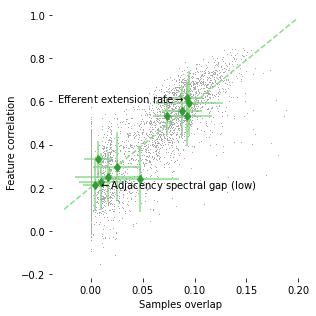

In [4]:
"""
Panel A: Average sample overlap vs feature correlation in champion samples
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
for x, spec in enumerate(specs_param):
    data_ovlp = ovlp.get2(sampling='Parameter', specifier=spec)
    data_cc = ec_cc_val.get2(sampling='Parameter', specifier=spec)
    if panel_a_show_points:
        ax.plot(data_ovlp, data_cc, marker=',', ls='None', color='darkgrey')
    mean_ovlp = numpy.mean(data_ovlp)
    mean_cc = numpy.mean(data_cc)
    std_ovlp = numpy.std(data_ovlp)
    std_cc = numpy.std(data_cc)
    if panel_a_show_errbars:
        ax.errorbar(mean_ovlp, mean_cc, xerr=std_ovlp, yerr=std_cc, marker='d', ls='None', color=col_param, ecolor=adjust_color_brightness(colors.to_rgb(col_param), 1.75))
    else:
        ax.plot(mean_ovlp, mean_cc, marker='o', ls='None', color=col_param)
    all_x.append(mean_ovlp)
    all_y.append(mean_cc)

data_fit = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Samples overlap')
ax.set_ylabel('Feature correlation')
# ax.axis('tight')
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit[1] + data_fit[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_param), 1.75) if panel_a_show_points else 'grey', ls='--')
plt.box(False)

# Annotations
for x, spec in enumerate(param_spec_sel):
    mean_ovlp = numpy.mean(ovlp.get2(sampling='Parameter', specifier=spec))
    mean_cc = numpy.mean(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    if mean_ovlp < numpy.mean(x_range):
        ax.text(mean_ovlp, mean_cc, r' $\leftarrow$' + spec, ha='left', va='center', color='k')
    else:
        ax.text(mean_ovlp, mean_cc, spec + r'$\rightarrow$ ', ha='right', va='center', color='k')

plt.tight_layout()
F.save(fig, "Panel-A")

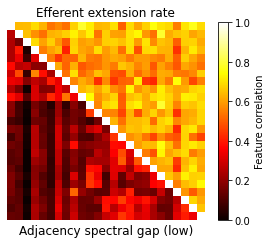

In [5]:
"""
Panel B: Two examples of sets of tribes with uncorrelated and highly correlated features
"""
# Pairwise feature correlation matrices (2 examples combined)
assert len(param_spec_sel) == 2, 'ERROR: Two specifiers required!'
fig = plt.figure(figsize=(4, 3.5))
cc_mat1 = ec_cc.get2(sampling='Parameter', specifier=param_spec_sel[0])
cc_mat2 = ec_cc.get2(sampling='Parameter', specifier=param_spec_sel[1])
cc_mat_comb = numpy.tril(cc_mat1, 0) + numpy.triu(cc_mat2, 1)
plt.imshow(cc_mat_comb, clim=(0, 1), cmap=cm.hot)
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.xlabel(param_spec_sel[0], fontsize=12)
plt.title(param_spec_sel[1], fontsize=12)
plt.tight_layout()
plt.colorbar(label='Feature correlation')
F.save(fig, "Panel-B")

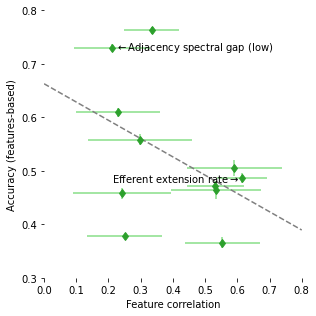

In [6]:
"""
Panel C: High average correlation leads to poor classification
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
for x, spec in enumerate(specs_param):
    mean_cc = numpy.mean(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='Parameter', specifier=spec))
    std_cc = numpy.std(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    std_acc = numpy.std(ftr_acc.get2(sampling='Parameter', specifier=spec))
    if panel_c_show_errbars:
        ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_param, ecolor=adjust_color_brightness(colors.to_rgb(col_param), 1.75))
    else:
        ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_param)
    all_x.append(mean_cc)
    all_y.append(mean_acc)

data_fit = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Feature correlation')
ax.set_ylabel('Accuracy (features-based)')
ax.axis('tight')
ax.set_xlim((numpy.floor(min(ax.get_xlim()) * 10) / 10, numpy.ceil(max(ax.get_xlim()) * 10) / 10))
ax.set_ylim((numpy.floor(min(ax.get_ylim()) * 10) / 10, numpy.ceil(max(ax.get_ylim()) * 10) / 10))
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit[1] + data_fit[0] * x_range, color='grey', ls='--')
plt.box(False)

# Annotations
for x, spec in enumerate(param_spec_sel):
    mean_cc = numpy.mean(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='Parameter', specifier=spec))
    if mean_cc < numpy.mean(x_range):
        ax.text(mean_cc, mean_acc, r' $\leftarrow$' + spec, ha='left', va='center', color='k')
    else:
        ax.text(mean_cc, mean_acc, spec + r'$\rightarrow$ ', ha='right', va='center', color='k')

plt.tight_layout()
F.save(fig, "Panel-C")

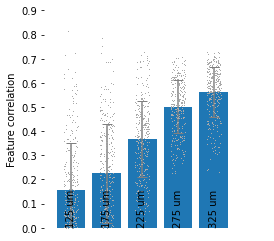

In [7]:
"""
Panel E1: Average feature correlation in volumetric samples
"""
specs_vol = ec_cc_val.filter(sampling='Radius').labels_of('specifier')

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
for x, spec in enumerate(specs_vol):
    data_cc = ec_cc_val.get2(sampling='Radius', specifier=spec)
    ax.bar(x, numpy.mean(data_cc), color=col_vol, width=0.8)
    if panel_e_show_points:
        ax.plot(x + 0.4 * (numpy.random.rand(len(data_cc)) - 0.5), data_cc, marker=',', ls='None', color='darkgrey')
    if panel_e_show_errbars:
        ax.errorbar(x, numpy.mean(data_cc), yerr=numpy.std(data_cc), color='grey', capsize=5)

ax.set_xticks(range(len(specs_vol)))
ax.set_xticklabels(specs_vol, rotation='vertical', va='bottom')
ax.tick_params(axis='x', length=0, pad=-1)
ax.set_ylabel('Feature correlation')
ax.set_xlim((-0.75, len(specs_vol) + 0.5))
ax.set_ylim((0, numpy.ceil(max(ax.get_ylim()) * 10) / 10))
ax.set_axisbelow(False)
plt.box(False)
F.save(fig, "Panel-E1")

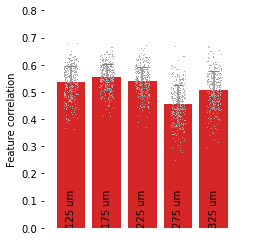

In [8]:
"""
Panel E2: Average feature correlation in subtribes samples
"""
specs_subtr = [spec + '@0' for spec in specs_vol] # Select first set of subtribes (..@0) consistent with specs_vol

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
for x, spec in enumerate(specs_subtr):
    data_cc = ec_cc_val.get2(sampling='subtribes', specifier=spec)
    ax.bar(x, numpy.mean(data_cc), color=col_subtr, width=0.8)
    if panel_e_show_points:
        ax.plot(x + 0.4 * (numpy.random.rand(len(data_cc)) - 0.5), data_cc, marker=',', ls='None', color='darkgrey')
    if panel_e_show_errbars:
        ax.errorbar(x, numpy.mean(data_cc), yerr=numpy.std(data_cc), color='grey', capsize=5)

ax.set_xticks(range(len(specs_subtr)))
ax.set_xticklabels(specs_vol, rotation='vertical', va='bottom')
ax.tick_params(axis='x', length=0, pad=-1)
ax.set_ylabel('Feature correlation')
ax.set_xlim((-0.75, len(specs_subtr) + 0.5))
ax.set_ylim((0, numpy.ceil(max(ax.get_ylim()) * 10) / 10))
plt.box(False)
F.save(fig, "Panel-E2")

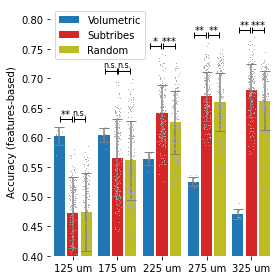

In [9]:
"""
Panel F: Overview of accuracies when using the largest 25 subtribes in volumetric samples
"""
specs_subtr = specs_vol
specs_subtr_suffix = [f'@{i}' for i in range(25)] # Select sets of subtribes belonging to volumetric samples (..@0, ..@1, ...) consistent with specs_vol
specs_rnd = specs_vol
specs_rnd_suffix = [f'@{i}' for i in range(25)] # Select sets of subtribes belonging to volumetric samples (..@0, ..@1, ...) consistent with specs_vol
# specs_rnd_suffix = [f'@{i}-{j}' for j in range(5) for i in range(1)] # Select sets of random subtribes (..-0, ..-1, ...) belonging to volumetric samples (..@0, ..@1, ...) consistent with specs_vol

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
bar_offset = {'Radius': -0.3, 'subtribes': 0.0, 'subtribes_random': 0.3}
data_all = {'Radius': {k: [] for k in specs_vol}, 'subtribes': {k: [] for k in specs_subtr}, 'subtribes_random': {k: [] for k in specs_rnd}}
for x, spec in enumerate(specs_vol):
    data_acc = ftr_acc.get2(sampling='Radius', specifier=spec)
    ax.bar(x + bar_offset['Radius'], numpy.mean(data_acc), color=col_vol, width=0.25, label='Volumetric' if x==0 else '')
    if panel_f_show_points:
        ax.plot(x + bar_offset['Radius'] + 0.15 * (numpy.random.rand(len(data_acc)) - 0.5), data_acc, marker=',', ls='None', color='darkgrey')
    if panel_f_show_errbars:
        ax.errorbar(x + bar_offset['Radius'], numpy.mean(data_acc), yerr=numpy.std(data_acc), color='grey', capsize=5)
    data_all['Radius'][spec] = numpy.hstack((data_all['Radius'][spec], data_acc))

for x, spec in enumerate(specs_subtr):
    data_acc = numpy.array([])
    for sfx in specs_subtr_suffix:
        data_acc = numpy.hstack((data_acc, ftr_acc.get2(sampling='subtribes', specifier=spec + sfx))) # Pooling instances
    ax.bar(x + bar_offset['subtribes'], numpy.mean(data_acc), color=col_subtr, width=0.25, label='Subtribes' if x==0 else '')
    if panel_f_show_points:
        ax.plot(x + bar_offset['subtribes'] + 0.15 * (numpy.random.rand(len(data_acc)) - 0.5), data_acc, marker=',', ls='None', color='darkgrey')
    if panel_f_show_errbars:
        ax.errorbar(x + bar_offset['subtribes'], numpy.mean(data_acc), yerr=numpy.std(data_acc), color='grey', capsize=5)
    data_all['subtribes'][spec] = numpy.hstack((data_all['subtribes'][spec], data_acc))

for x, spec in enumerate(specs_rnd):
    data_acc = numpy.array([])
    for sfx in specs_rnd_suffix:
        data_acc = numpy.hstack((data_acc, ftr_acc.get2(sampling='subtribes_random', specifier=spec + sfx))) # Pooling instances
    ax.bar(x + bar_offset['subtribes_random'], numpy.mean(data_acc), color=col_rnd, width=0.25, label='Random' if x==0 else '')
    if panel_f_show_points:
        ax.plot(x + bar_offset['subtribes_random'] + 0.15 * (numpy.random.rand(len(data_acc)) - 0.5), data_acc, marker=',', ls='None', color='darkgrey')
    if panel_f_show_errbars:
        ax.errorbar(x + bar_offset['subtribes_random'], numpy.mean(data_acc), yerr=numpy.std(data_acc), color='grey', capsize=5)
    data_all['subtribes_random'][spec] = numpy.hstack((data_all['subtribes_random'][spec], data_acc))

# Pairwise significance tests
if panel_f_show_significance:
    test_pairs = ((('Radius', 'subtribes'), lambda x, y: ranksums(x, y).pvalue), (('subtribes', 'subtribes_random'), lambda x, y: wilcoxon(x, y).pvalue))
    num_tests = len(specs_vol) * len(test_pairs)
    alpha_levels = numpy.power(10.0, [-2, -3, -4]) # Corresponding to *, **, and ***
    alpha_levels_corr = alpha_levels / num_tests # Bonferroni correction for multiple comparisons
    max_vals = numpy.array([numpy.max(numpy.hstack([data_all[k][spec] for k in data_all.keys()])) for spec in specs_vol])
    x_offset = 0.02
    y_offset = 0.015
    for x, spec in enumerate(specs_vol):
        for pair, stattest in test_pairs:
            pval = stattest(data_all[pair[0]][spec], data_all[pair[1]][spec])
            ax.plot([x + bar_offset[pair[0]] + x_offset, x + bar_offset[pair[1]] - x_offset], [max_vals[x] + 1 * y_offset] * 2, '-k|', linewidth=1)
            if numpy.any(pval < alpha_levels_corr):
                ax.text(numpy.mean([x + bar_offset[pair[0]] + x_offset, x + bar_offset[pair[1]] - x_offset]), max_vals[x] + 1.5 * y_offset, '*' * numpy.sum(pval < alpha_levels_corr), ha='center', va='center', fontsize=10)
            else:
                ax.text(numpy.mean([x + bar_offset[pair[0]] + x_offset, x + bar_offset[pair[1]] - x_offset]), max_vals[x] + 1.75 * y_offset, 'n.s.', ha='center', va='center', fontsize=8)

# ax.autoscale(tight=True)
ax.set_xticks(range(len(specs_vol)))
ax.set_xticklabels(specs_vol)
ax.set_ylabel('Accuracy (features-based)')
ax.set_xlim((-0.5, len(specs_vol) - 0.5))
ax.set_ylim((0.4, max(ax.get_ylim())))
plt.legend(loc='upper left')
plt.box(False)
plt.tight_layout()
F.save(fig, "Panel-F")

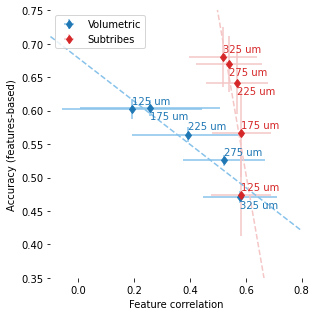

In [10]:
"""
Panel G: Feature correlation vs accuracy based on subtribes in volumetric samples
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()

# Volumetric
all_x = []
all_y = []
spec_va = ['bottom', 'top', 'bottom', 'bottom', 'top']
for x, spec in enumerate(specs_vol):
    mean_cc = numpy.mean(ec_cc.get2(sampling='Radius', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='Radius', specifier=spec))    
    std_cc = numpy.std(ec_cc.get2(sampling='Radius', specifier=spec))
    std_acc = numpy.std(ftr_acc.get2(sampling='Radius', specifier=spec))    
    if panel_g_show_errbars:
        ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_vol, ecolor=adjust_color_brightness(colors.to_rgb(col_vol), 1.75), label='Volumetric' if x==0 else '')
    else:
        ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_vol, label='Volumetric' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.005
    elif spec_va[x] == 'top':
        y_offset = -0.005
    else:
        y_offset = 0.0
    ax.text(mean_cc, mean_acc + y_offset, spec, ha='left', va=spec_va[x], color=col_vol)
    all_x.append(mean_cc)
    all_y.append(mean_acc)

data_fit_vol = numpy.polyfit(all_x, all_y, deg=1)

# Subtribes
all_x = []
all_y = []
spec_va = ['bottom', 'bottom', 'top', 'top', 'bottom']
for x, spec in enumerate(specs_subtr):
    data_cc = numpy.array([])
    data_acc = numpy.array([])    
    for sfx in specs_subtr_suffix:
        data_cc = numpy.hstack((data_cc, ec_cc.get2(sampling='subtribes', specifier=spec + sfx).flatten())) # Pooling instances
        data_acc = numpy.hstack((data_acc, ftr_acc.get2(sampling='subtribes', specifier=spec + sfx))) # Pooling instances
    mean_cc = numpy.mean(data_cc)
    mean_acc = numpy.mean(data_acc)
    std_cc = numpy.std(data_cc)
    std_acc = numpy.std(data_acc)
    if panel_g_show_errbars:
        ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_subtr, ecolor=adjust_color_brightness(colors.to_rgb(col_subtr), 1.75), label='Subtribes' if x==0 else '')
    else:
        ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_subtr, label='Subtribes' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.005
    elif spec_va[x] == 'top':
        y_offset = -0.005
    else:
        y_offset = 0.0
    ax.text(mean_cc, mean_acc + y_offset, specs_vol[x], ha='left', va=spec_va[x], color=col_subtr)
    all_x.append(mean_cc)
    all_y.append(mean_acc)

data_fit_subtr = numpy.polyfit(all_x, all_y, deg=1)

# Subtribes - random control (optional)
if panel_g_show_random:
    all_x = []
    all_y = []
    spec_va = ['bottom', 'bottom', 'bottom', 'top', 'bottom']
    for x, spec in enumerate(specs_subtr):
        data_cc = numpy.array([])
        data_acc = numpy.array([])    
        for sfx in specs_subtr_suffix:
            data_cc = numpy.hstack((data_cc, ec_cc.get2(sampling='subtribes_random', specifier=spec + sfx).flatten())) # Pooling instances
            data_acc = numpy.hstack((data_acc, ftr_acc.get2(sampling='subtribes_random', specifier=spec + sfx))) # Pooling instances
        mean_cc = numpy.mean(data_cc)
        mean_acc = numpy.mean(data_acc)
        std_cc = numpy.std(data_cc)
        std_acc = numpy.std(data_acc)
        if panel_g_show_errbars:
            ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_rnd, ecolor=adjust_color_brightness(colors.to_rgb(col_rnd), 1.75), label='Subtribes' if x==0 else '')
        else:
            ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_rnd, label='Random' if x==0 else '')
        if spec_va[x] == 'bottom':
            y_offset = 0.005
        elif spec_va[x] == 'top':
            y_offset = -0.005
        else:
            y_offset = 0.0
        ax.text(mean_cc, mean_acc + y_offset, specs_vol[x], ha='left', va=spec_va[x], color=col_rnd)
        all_x.append(mean_cc)
        all_y.append(mean_acc)

    data_fit_rnd = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Feature correlation')
ax.set_ylabel('Accuracy (features-based)')
ax.axis('tight')
ax.set_xlim((numpy.floor(min(ax.get_xlim()) * 10) / 10, numpy.ceil(max(ax.get_xlim()) * 10) / 10))
ax.set_ylim((numpy.floor(min(ax.get_ylim()) * 20) / 20, numpy.ceil(max(ax.get_ylim()) * 20) / 20))
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit_vol[1] + data_fit_vol[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_vol), 1.75), ls='--')
ax.plot(x_range, data_fit_subtr[1] + data_fit_subtr[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_subtr), 1.75), ls='--')
if panel_g_show_random:
    ax.plot(x_range, data_fit_rnd[1] + data_fit_rnd[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_rnd), 1.75), ls='--')
plt.box(False)
plt.legend(loc='upper left')
plt.tight_layout()
F.save(fig, "Panel-G")